In [1]:
%load_ext autoreload
%autoreload 2
from Modules import *
from Examples import *

In [9]:
world = World()

agents_generator = AgentsFactory()
controllers_handler = ControllerFactory(world=world)


agents_generator.register_manager("unicycle_Collision_Avoidance",world)

controllers_handler.register_controller(name = "CollisionAvoidance",
                                        controller=ECC_CollisionAvoidance_PathFollowing)






world.initialize(init_time=0,
                 ode_solver='lsoda',
                 ode_dt=1e-2)



Collision_Activated = True
r_min = .5
R_min = 3
K =1
m_vel = 1e6
CA_controller_1 = controllers_handler.get_controller(name = "CollisionAvoidance",
                                                     distination = [3,-3],
                                                     detection_radius=R_min,
                                                     r=r_min,
                                                     activate_CA=True,
                                                     gain_CA=K,
                                                     max_velocity=m_vel)
    
CA_controller_2 = controllers_handler.get_controller(name = "CollisionAvoidance",
                                                     distination = [3,3],
                                                     detection_radius=R_min,
                                                     r=r_min,
                                                     activate_CA=True,
                                                     gain_CA=K,
                                                     max_velocity=m_vel)

CA_controller_3 = controllers_handler.get_controller(name = "CollisionAvoidance",
                                                     distination = [-3,-3],
                                                     detection_radius=R_min,
                                                     r=r_min,
                                                     activate_CA=True,
                                                     gain_CA=K,
                                                     max_velocity=m_vel)

CA_controller_4 = controllers_handler.get_controller(name = "CollisionAvoidance",
                                                     distination = [-3,3],
                                                     detection_radius=R_min,
                                                     r=r_min,
                                                     activate_CA=True,
                                                     gain_CA=K,
                                                     max_velocity=m_vel)

agent_1 = agents_generator("unicycle_Collision_Avoidance",
                            name="Ego", 
                            AgentClass=Unicycle, 
                            x_init=[-3,4,-np.pi/4+.5],
                            save_history = True,
                            controller=CA_controller_1)
    
agent_2 = agents_generator("unicycle_Collision_Avoidance",
                            name="obstacle_1", 
                            AgentClass=Unicycle, 
                            x_init=[-3,-3,np.pi/4-.5],
                            save_history=True,
                            controller=CA_controller_2)

agent_3 = agents_generator("unicycle_Collision_Avoidance",
                            name="obstacle_2", 
                            AgentClass=Unicycle, 
                            x_init=[3,3,-3*np.pi/4+.3],
                            save_history=True,
                            controller=CA_controller_3)

agent_4 = agents_generator("unicycle_Collision_Avoidance",
                            name="obstacle_3", 
                            AgentClass=Unicycle, 
                            x_init=[4,-4.5,3*np.pi/4],
                            save_history=True,
                            controller=CA_controller_4)

t_horizon = 14
world(t_horizon,100)

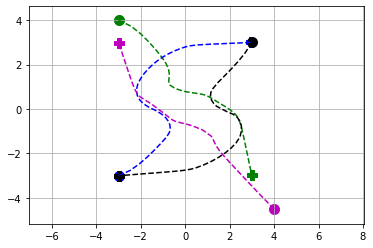

In [10]:
render = Render(world=world)
kwargs = {"axis":"equal",
          "grid":None}
# kwargs = {}
fig,ax = render.plot(**kwargs)

#Make Video

In [11]:
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from matplotlib import gridspec 

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
        comment='Movie support!')
writer = FFMpegWriter(fps=10, metadata=metadata)

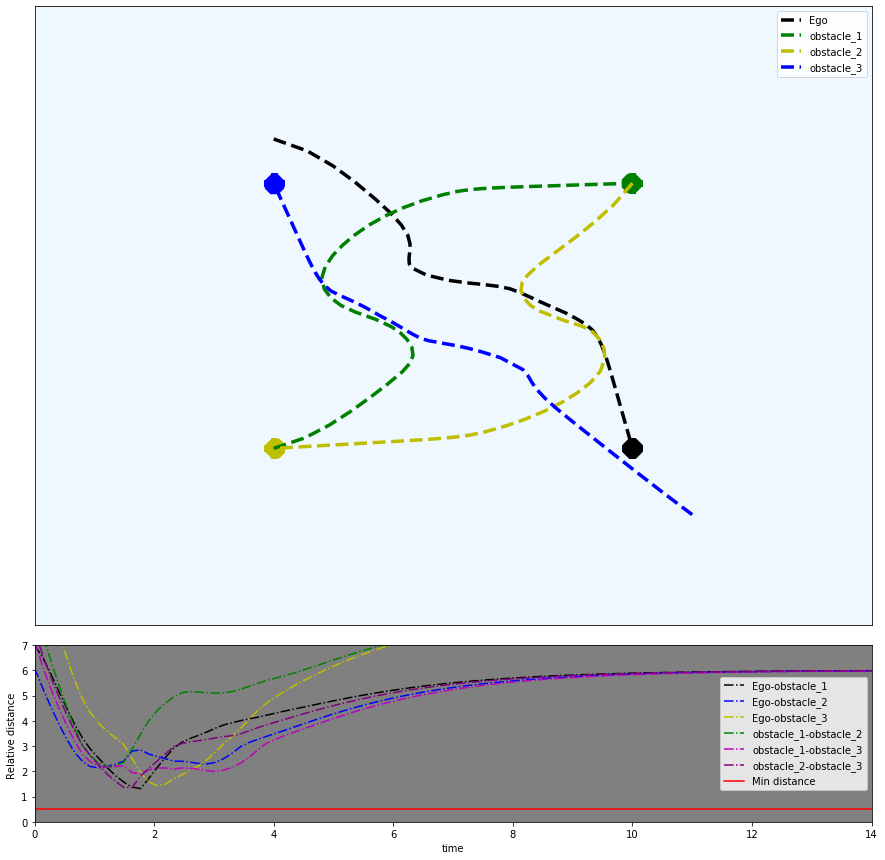

In [12]:
render = Render(world=world)
all_agents = render.get_agents()

nb_points = len(list(all_agents.values())[1].history["x"])

# r_min=.5

def get_axes(fig,marker_size=100,t_horizon=10):
    l_paths = []
    l_poss = []
    l_rhos = []
    
    # specify the ratio for each subplot
    gs = gridspec.GridSpec(2, 1, height_ratios=[3.5, 1])
    ax_path = fig.add_subplot(gs[0])
    ax_rho = fig.add_subplot(gs[1])
    
    
    #remove the axis from the World dispaly
    ax_path.get_xaxis().set_visible(False)
    ax_path.get_yaxis().set_visible(False)
    
    ax_path.set_facecolor("aliceblue")
    ax_path.set_xlim(-7,7)
    ax_path.set_ylim(-7,7)
    
    ax_rho.set_xlim(0,t_horizon)
    ax_rho.set_ylim(0,7)
    ax_rho.set_yscale("linear")
    ax_rho.set_facecolor("grey")
    ax_rho.set_ylabel("Relative distance ")
    ax_rho.set_xlabel("time")
    
    for agent in all_agents.values():
        marker = render.get_marker(agent)
        marker = "P"
        color = render.get_color(agent)
        destination = agent.get_destination()

        l_paths.append(ax_path.plot([],[],color=color,linestyle='dashed',linewidth=3.5,label=agent.name)[0])
        l_poss.append(ax_path.scatter([],[],
                                       c=color,
                                       marker='8',
                                       s=marker_size))
        ax_path.scatter([destination[0]],[destination[1]],
                                       c=color,
                                       marker='P',
                                       s=marker_size)
        
    agents = list(all_agents.values())
    
    colors_list = iter(["k","b","y","g","m","purple"])
    random_color = lambda  :next(colors_list)
    
    for i in range(len(agents)):
        for j in range(i+1,len(agents)):
            label = "{}-{}".format(agents[i].name,agents[j].name)
            l_rhos.append(ax_rho.plot([],[],color=random_color(),linestyle='dashdot',label=label)[0])
    
    l_rhos.append(ax_rho.plot(np.linspace(-14,14,100),r_min*np.ones([100,1]),color="r",label="Min distance")[0])
    
    ax_path.legend()
    ax_rho.legend()
    return l_paths,l_poss,l_rhos,fig
    

fig = plt.figure(figsize=(15,15))  

l_paths,l_poss,l_rhos,fig = get_axes(fig,400,t_horizon)
# fig, (ax1, ax2) = plt.subplots(2,1)



rhos = {}

with writer.saving(fig, "videos/ece_test.mp4", dpi=100):
    fig.subplots_adjust(hspace=.05)#bottom=-1,right=1.5,top=1.5,
    agents = list(all_agents.values())
    for k in range(nb_points):
        cnt = 0
        for i in range(len(agents)):   
            for j in range(i+1,len(agents)):
                if rhos.get((i,j)) is None:
                    rhos[(i,j)] = []
                ag_i = agents[i]
                ag_j = agents[j]

                x_i = np.array(ag_i.history["x"])[k,:-1]
                x_j = np.array(ag_j.history["x"])[k,:-1]
                t = ag_i.history["t"][k]
        #                 print(np.shape(x_i))
                rhos[(i,j)].append([t,np.linalg.norm(x_i-x_j,2)])
                r = np.array(rhos[(i,j)])
                l_rhos[cnt].set_data(r[:,0],r[:,1])
                
                cnt += 1
#                 l_rhos[1].set_data(r[:,0],r_min*np.ones(np.shape(r[:,0])))
        
    
        for l_path, l_pos, agent in zip(l_paths,l_poss,all_agents.values()):
            states = agent.history["x"]
            x = np.array(states)
            l_path.set_data(x[:k,0],x[:k,1])
            l_pos.set_offsets(np.c_[x[k-1,0],x[k-1,1]])
        writer.grab_frame()
             
        
        
                
        

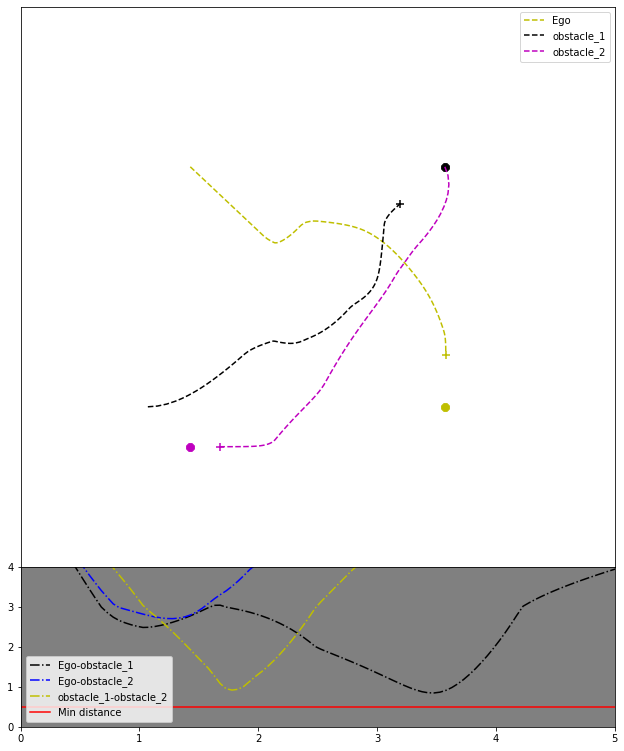

In [48]:
fig.

3

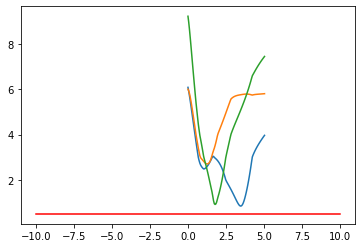

In [28]:
for rho in rhos.values():
    plt.plot(np.array(rho)[:,0],np.array(rho)[:,1])
    
plt.plot(np.linspace(-10,10,100),r_min*np.ones([100,1]),color="r",label="Min distance")

len(rhos)

In [2]:
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
        comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

fig = plt.figure()
# l, = plt.plot([], [], 'k-o')



plt.xlim(-5, 5)
plt.ylim(-5, 5)

x0,y0 = 0, 0

with writer.saving(fig, "videos/writer_test.mp4", 100):
    for i in range(100):
        x0 += 0.1 * np.random.randn()
        y0 += 0.1 * np.random.randn()
        l.set_data(x0, y0)
        writer.grab_frame()

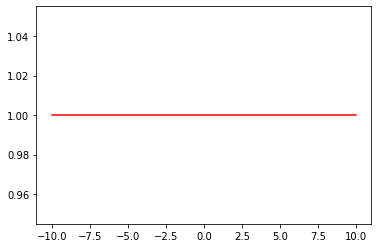

In [55]:
plt.plot(np.linspace(-10,10,100),np.ones([100,1]),color="r",label="Min distance")

In [156]:
tmp.get('a') is None

False

In [71]:
l = {}
i=1
l[(1,2)] = 4
l[(i,2)]

4

In [17]:
np.max(-2

-2